In [5]:
!pip install wordcloud


Dataset shape: (235795, 56)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    235795 non-null  object 
 1   URL                         235795 non-null  object 
 2   URLLength                   235795 non-null  int64  
 3   Domain                      235795 non-null  object 
 4   DomainLength                235795 non-null  int64  
 5   IsDomainIP                  235795 non-null  int64  
 6   TLD                         235795 non-null  object 
 7   URLSimilarityIndex          235795 non-null  float64
 8   CharContinuationRate        235795 non-null  float64
 9   TLDLegitimateProb           235795 non-null  float64
 10  URLCharProb                 235795 non-null  float64
 11  TLDLength                   235795 non-null  int64  
 12  NoOfSubDomain               2

C:\Users\91914\AppData\Local\Temp\ipykernel_29668\3957877276.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], palette="Set2")


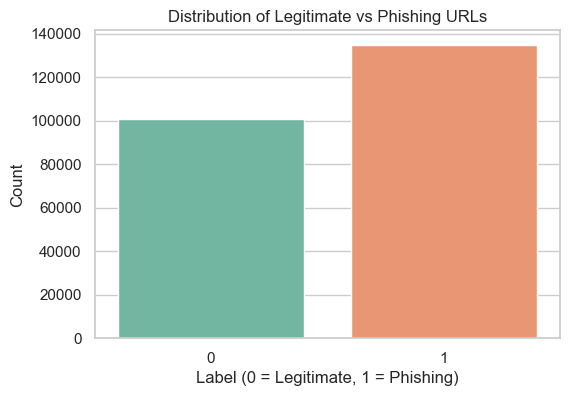

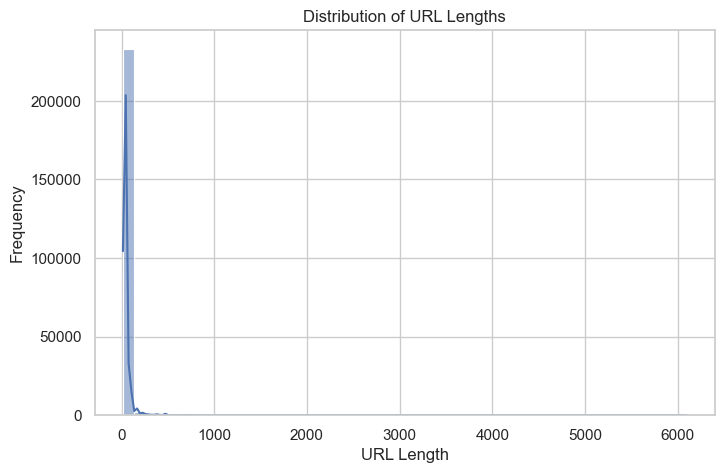

C:\Users\91914\AppData\Local\Temp\ipykernel_29668\3957877276.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='URL_length', data=df, palette="Set2")


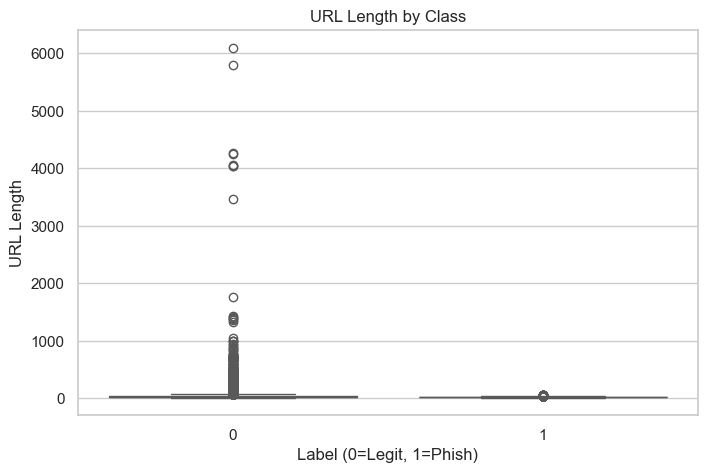


Average phishing URL length: 27.228609566184648
Average legitimate URL length: 46.238773589578486


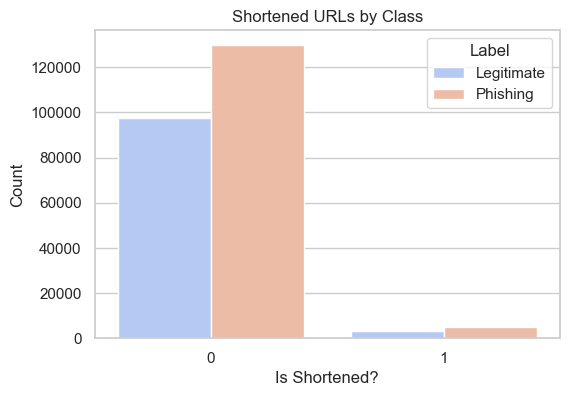


Shortened URL Distribution:
is_shortened  label
0             0         97557
              1        129889
1             0          3388
              1          4961
dtype: int64


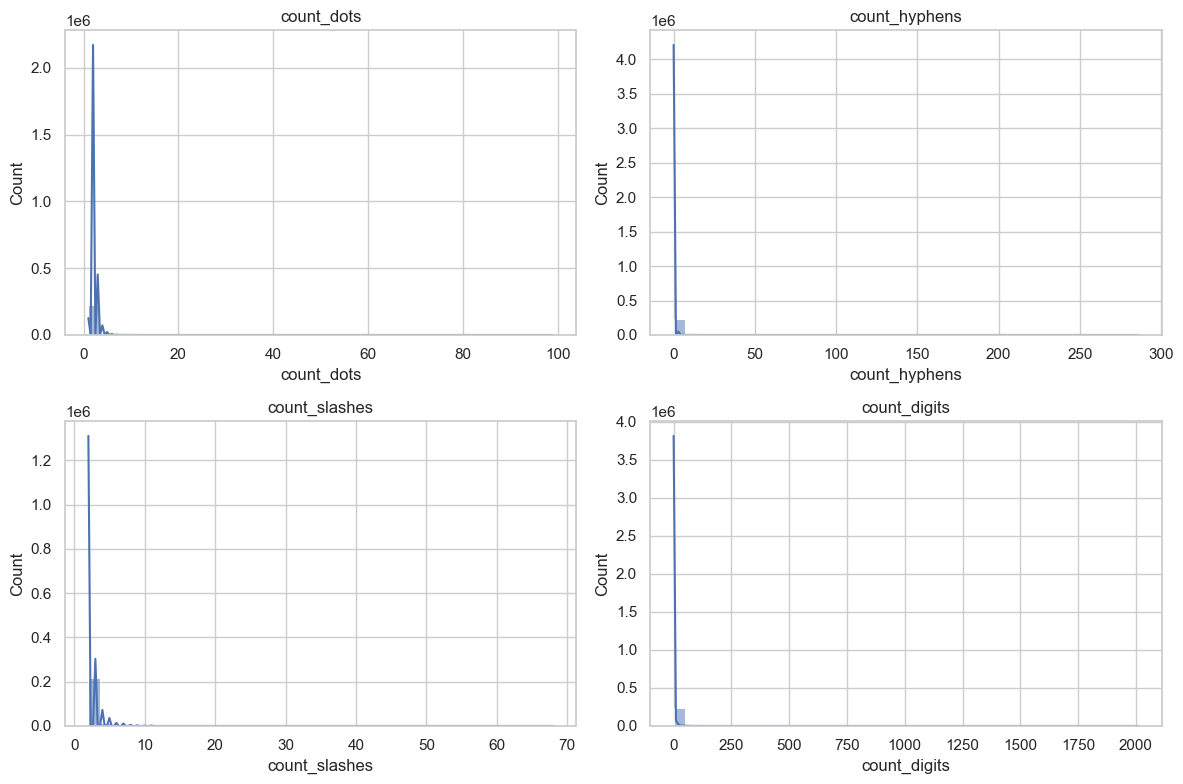


Keyword occurrences in phishing URLs:
{'login': np.int64(13), 'verify': np.int64(3), 'secure': np.int64(22), 'update': np.int64(21), 'confirm': np.int64(4), 'account': np.int64(23), 'bank': np.int64(332), 'payment': np.int64(16)}


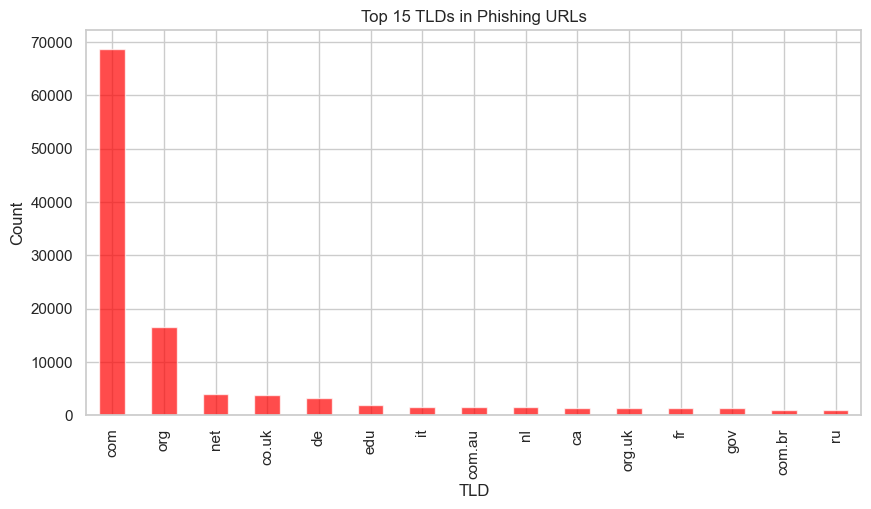

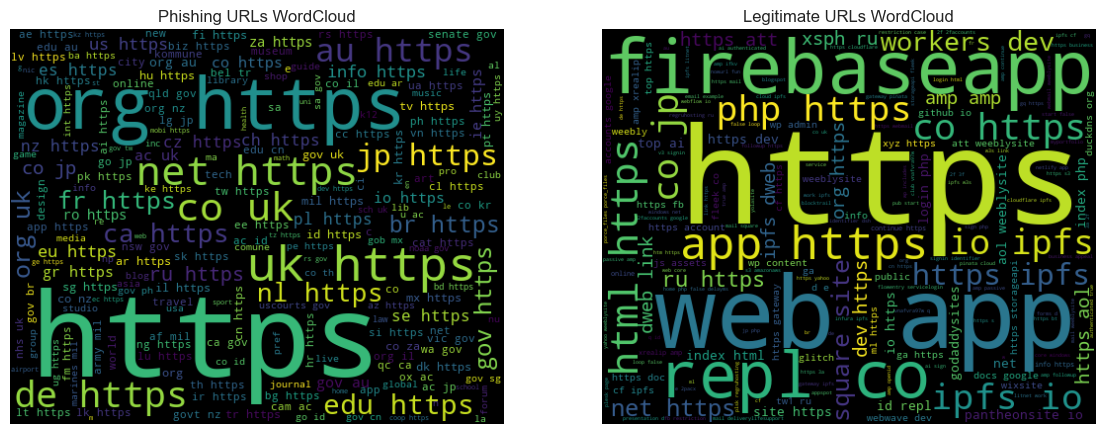

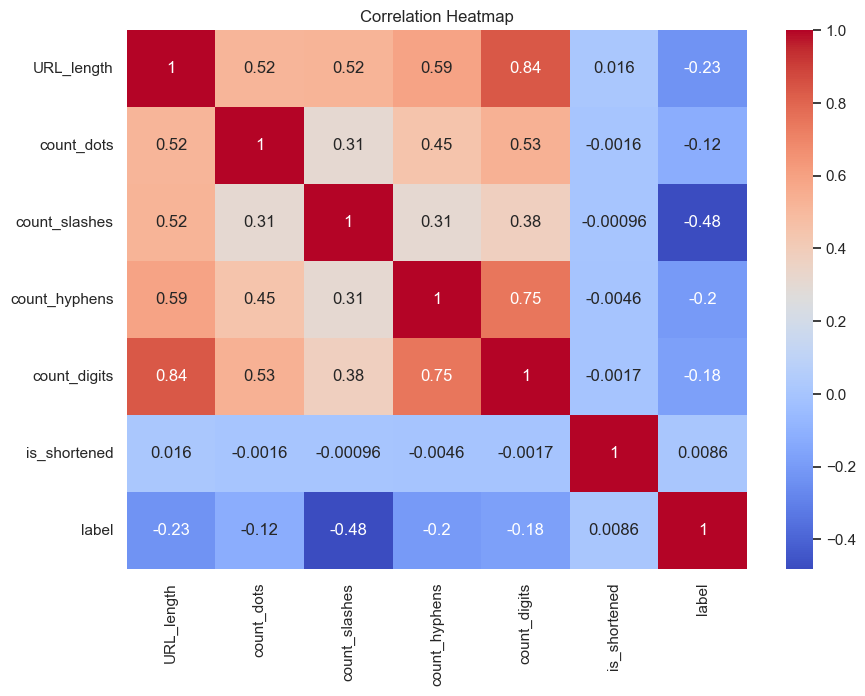


Processed dataset saved at data/processed_dataset.csv


In [7]:
# ---------------------------------------------------------
# Enhanced EDA for Phishing URL Detection
# ---------------------------------------------------------
# Author: Siddhesh Sathyamoorthy
# Description:
#   This notebook performs in-depth Exploratory Data Analysis (EDA) on a phishing URL dataset.
#   It focuses on lexical patterns, suspicious keywords, shortened links, and anomalies
#   (e.g., phishing URLs being shorter than legitimate URLs).
# ---------------------------------------------------------

# ==============================
# 1. Import Required Libraries
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tldextract
from wordcloud import WordCloud

# Display settings
pd.set_option('display.max_colwidth', 150)
sns.set(style="whitegrid")

# ==============================
# 2. Load Dataset
# ==============================
# Replace this with your dataset path
df = pd.read_csv(r"E:\Projects\CyberSec\NLP based URL phishing\NLP-phishingURL-detection\data\PhiUSIIL_Phishing_URL_Dataset_UCIrvine.csv")
print("Dataset shape:", df.shape)
df.head()

# ==============================
# 3. Basic Data Overview
# ==============================
print("\nDataset Info:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nClass Distribution:")
print(df['label'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x=df['label'], palette="Set2")
plt.title("Distribution of Legitimate vs Phishing URLs")
plt.xlabel("Label (0 = Legitimate, 1 = Phishing)")
plt.ylabel("Count")
plt.show()

# ==============================
# 4. URL Length Analysis
# ==============================
df['URL_length'] = df['URL'].apply(len)

plt.figure(figsize=(8,5))
sns.histplot(df['URL_length'], bins=50, kde=True)
plt.title("Distribution of URL Lengths")
plt.xlabel("URL Length")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='label', y='URL_length', data=df, palette="Set2")
plt.title("URL Length by Class")
plt.xlabel("Label (0=Legit, 1=Phish)")
plt.ylabel("URL Length")
plt.show()

print("\nAverage phishing URL length:", df[df['label']==1]['URL_length'].mean())
print("Average legitimate URL length:", df[df['label']==0]['URL_length'].mean())

# ==============================
# 5. Detect Shortened URLs
# ==============================
shorteners = ['bit.ly', 'goo.gl', 'tinyURL', 't.co', 'ow.ly', 'is.gd']
df['is_shortened'] = df['URL'].apply(lambda x: 1 if any(s in x.lower() for s in shorteners) else 0)

plt.figure(figsize=(6,4))
sns.countplot(x='is_shortened', hue='label', data=df, palette="coolwarm")
plt.title("Shortened URLs by Class")
plt.xlabel("Is Shortened?")
plt.ylabel("Count")
plt.legend(title="Label", labels=["Legitimate", "Phishing"])
plt.show()

print("\nShortened URL Distribution:")
print(df.groupby(['is_shortened','label']).size())

# ==============================
# 6. Special Character Counts
# ==============================
df['count_dots'] = df['URL'].apply(lambda x: x.count('.'))
df['count_hyphens'] = df['URL'].apply(lambda x: x.count('-'))
df['count_slashes'] = df['URL'].apply(lambda x: x.count('/'))
df['count_digits'] = df['URL'].apply(lambda x: len(re.findall(r'\d', x)))

features = ['count_dots', 'count_hyphens', 'count_slashes', 'count_digits']
plt.figure(figsize=(12,8))
for i, feature in enumerate(features, 1):
    plt.subplot(2,2,i)
    sns.histplot(df[feature], bins=40, kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()

# ==============================
# 7. Suspicious Keyword Analysis
# ==============================
keywords = ['login', 'verify', 'secure', 'update', 'confirm', 'account', 'bank', 'payment']
for word in keywords:
    df[f'keyword_{word}'] = df['URL'].apply(lambda x: 1 if word in x.lower() else 0)

phishing_keywords = {word: df[df['label']==1][f'keyword_{word}'].sum() for word in keywords}
print("\nKeyword occurrences in phishing URLs:")
print(phishing_keywords)

# ==============================
# 8. Domain & TLD Extraction
# ==============================
df['domain'] = df['URL'].apply(lambda x: tldextract.extract(x).domain)
df['suffix'] = df['URL'].apply(lambda x: tldextract.extract(x).suffix)

plt.figure(figsize=(10,5))
df[df['label']==1]['suffix'].value_counts().head(15).plot(kind='bar', color='red', alpha=0.7)
plt.title("Top 15 TLDs in Phishing URLs")
plt.xlabel("TLD")
plt.ylabel("Count")
plt.show()

# ==============================
# 9. WordCloud Visualization
# ==============================
phishing_URLs = " ".join(df[df['label']==1]['URL'])
legit_URLs = " ".join(df[df['label']==0]['URL'])

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
wc = WordCloud(width=500, height=400, background_color='black').generate(phishing_URLs)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Phishing URLs WordCloud")

plt.subplot(1,2,2)
wc = WordCloud(width=500, height=400, background_color='black').generate(legit_URLs)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Legitimate URLs WordCloud")
plt.show()

# ==============================
# 10. Correlation Heatmap
# ==============================
plt.figure(figsize=(10,7))
sns.heatmap(df[['URL_length','count_dots','count_slashes','count_hyphens','count_digits','is_shortened','label']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# ==============================
# 11. Save Processed Dataset
# ==============================
df.to_csv("data/processed_dataset.csv", index=False)
print("\nProcessed dataset saved at data/processed_dataset.csv")
